# Testing Individual Images
### Use techniques we've already learned in class to try and make progress on identifying roads

Imports

In [33]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skimor
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

### Read data file and show images

In [8]:
image_filepath = "../data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels

In [9]:
image = skio.imread(image_filepath + "/train/10078675_15.tiff")
image_label = skio.imread(image_filepath + "/train_labels/10078675_15.tif")

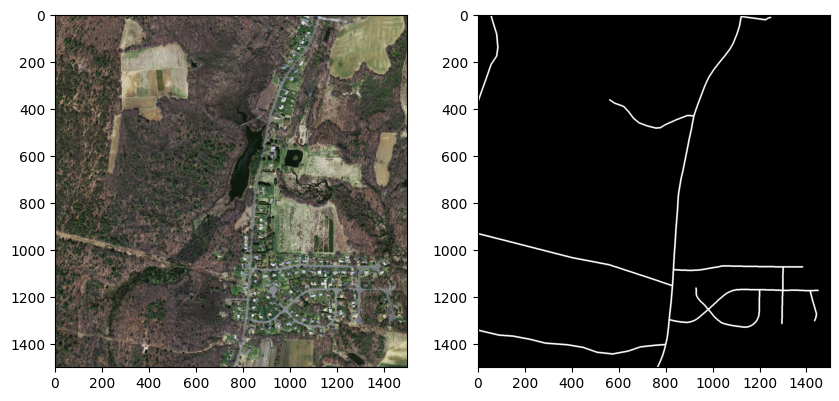

In [11]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(image)
axes[1].imshow(image_label, cmap='gray')

plt.show()

### Function for calculating label accuracy

In [12]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred)

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # True positive rate
    tpr = (C[0,0])/(C[0,0] + C[0,1])
    
    # True negative rate
    tnr = (C[1,1])/(C[1,0] + C[1,1])

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nTrue positive rate (not road):", np.round(tpr, 3),
            "\nTrue negative rate (roads)", np.round(tnr, 3)) 

In [13]:
#what values are used in label image
np.unique(image_label)

array([  0, 255], dtype=uint8)

Cropping Image for testing

In [14]:
x1, y1 = 750, 900
x2, y2 = 1500, 1500

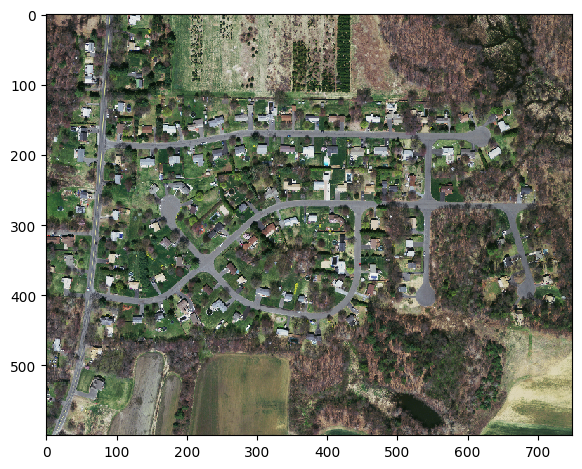

In [15]:
image = image[y1:y2, x1:x2, :]
skio.imshow(image)

### Reshape image

In [17]:
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

### K means clustering from OpenCV
https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/

In [18]:
#the below line of code defines the criteria for the algorithm to stop running, 
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

In [19]:
np.unique(segmented_image)

array([ 51,  57,  64,  90, 109, 148, 164, 165], dtype=uint8)

That's weird, I chose 2 clusters but we have more than two values in the segmented image, maybe this is just for visualization?

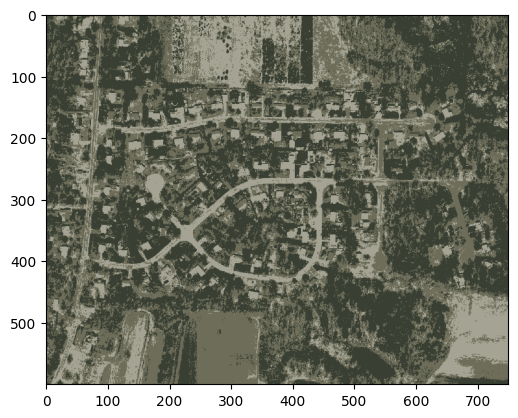

In [20]:
plt.imshow(segmented_image)

### K means from sklearn

In [21]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(pixel_vals)

Initialization complete
Iteration 0, inertia 940450368.0.
Iteration 1, inertia 562018176.0.
Iteration 2, inertia 529316768.0.
Iteration 3, inertia 523868608.0.
Iteration 4, inertia 522956544.0.
Iteration 5, inertia 522773152.0.
Iteration 6, inertia 522707264.0.
Converged at iteration 6: center shift 0.16912633180618286 within tolerance 0.17871517333984377.


In [22]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


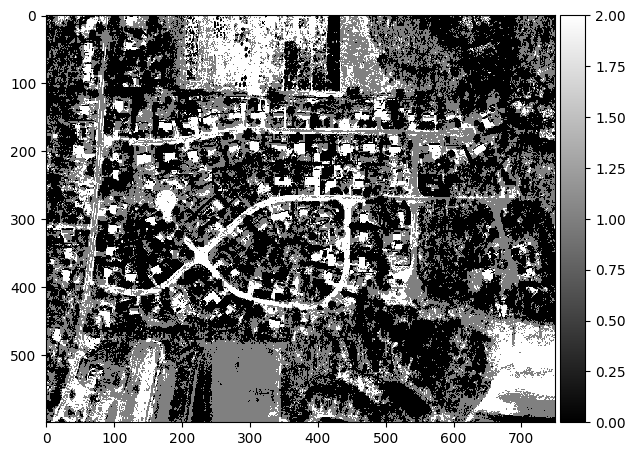

In [23]:
skio.imshow(sk_segmented_image, cmap='gray')

### Let's try to input a few more things into the model

Let's try to put a horizontal and vertically run edge detection using Sobel kernels

In [24]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

# Perform convolutions
edges_horizontal = convolve2d(image_gray, sobel_horizontal, mode='same', boundary='symm')
edges_vertical = convolve2d(image_gray, sobel_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


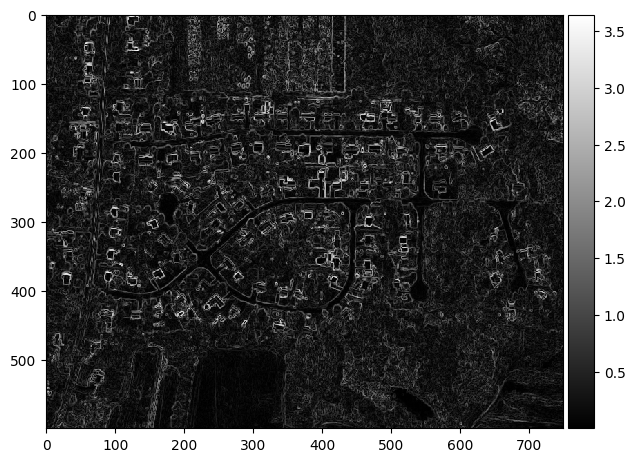

In [25]:
skio.imshow(edges, cmap='gray')

Let's see if canny edge detection works better

In [35]:
# Calculation Canny gradient
canny_edges = feature.canny(image_gray, sigma=3)

### Dilation to create crisper edges

In [34]:
# Create disk
disk = skimor.disk(1)

# Area closing
closed_edges = skimor.dilation(canny_edges, footprint = disk)

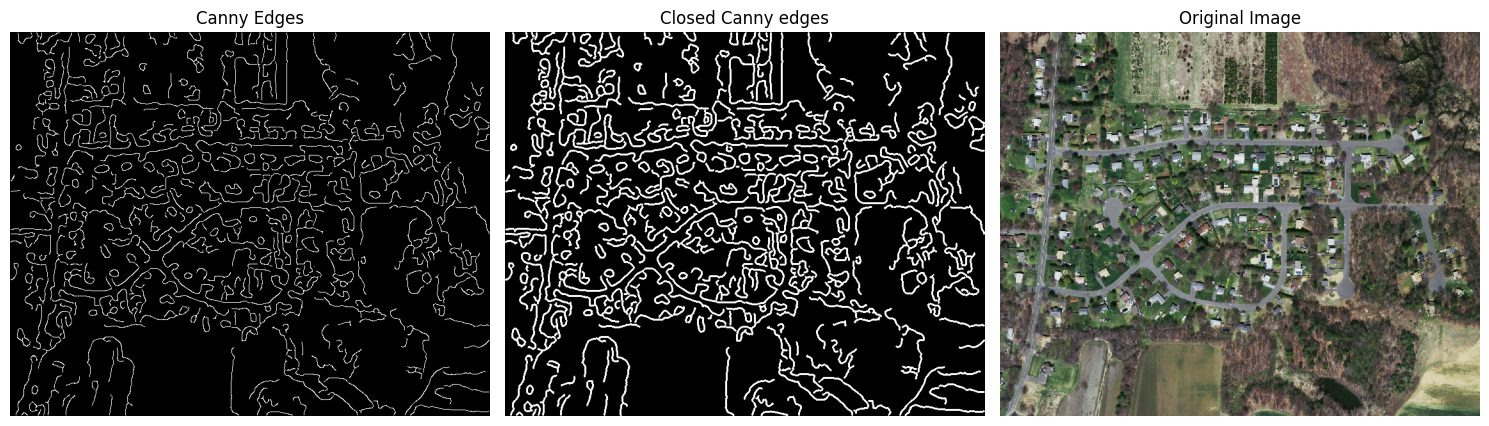

In [37]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(canny_edges, cmap='gray')
ax[0].set_title('Canny Edges')

ax[1].imshow(closed_edges, cmap='gray')
ax[1].set_title('Closed Canny edges')

ax[2].imshow(image)
ax[2].set_title('Original Image')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Now lets add this new channel to the image and see what happens

In [38]:
image_with_canny = np.dstack((image, closed_edges.astype(np.uint8) * 255))

In [39]:
feature_vals = image_with_canny.reshape((-1,4))
feature_vals = np.float32(feature_vals)

In [41]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(feature_vals)

Initialization complete
Iteration 0, inertia 1835825024.0.
Iteration 1, inertia 1224165248.0.
Iteration 2, inertia 1164440064.0.
Iteration 3, inertia 1144276992.0.
Iteration 4, inertia 1137567360.0.
Iteration 5, inertia 1135281920.0.
Iteration 6, inertia 1134506496.0.
Iteration 7, inertia 1134235776.0.
Converged at iteration 7: center shift 0.32159698009490967 within tolerance 0.349539697265625.


In [59]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


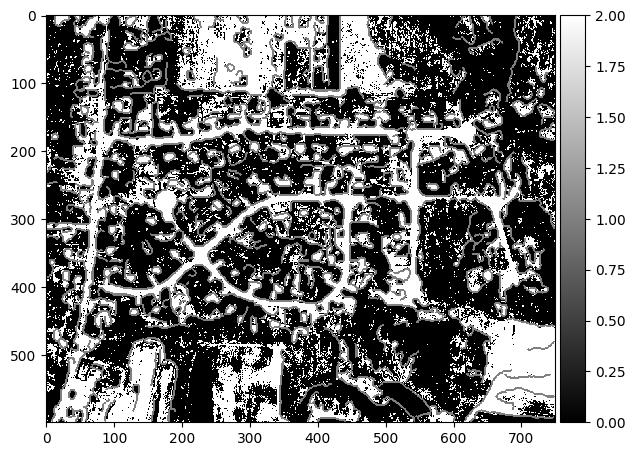

In [60]:
skio.imshow(sk_segmented_image, cmap='gray')

In [61]:
np.unique(sk_segmented_image)

array([0, 1, 2], dtype=int32)

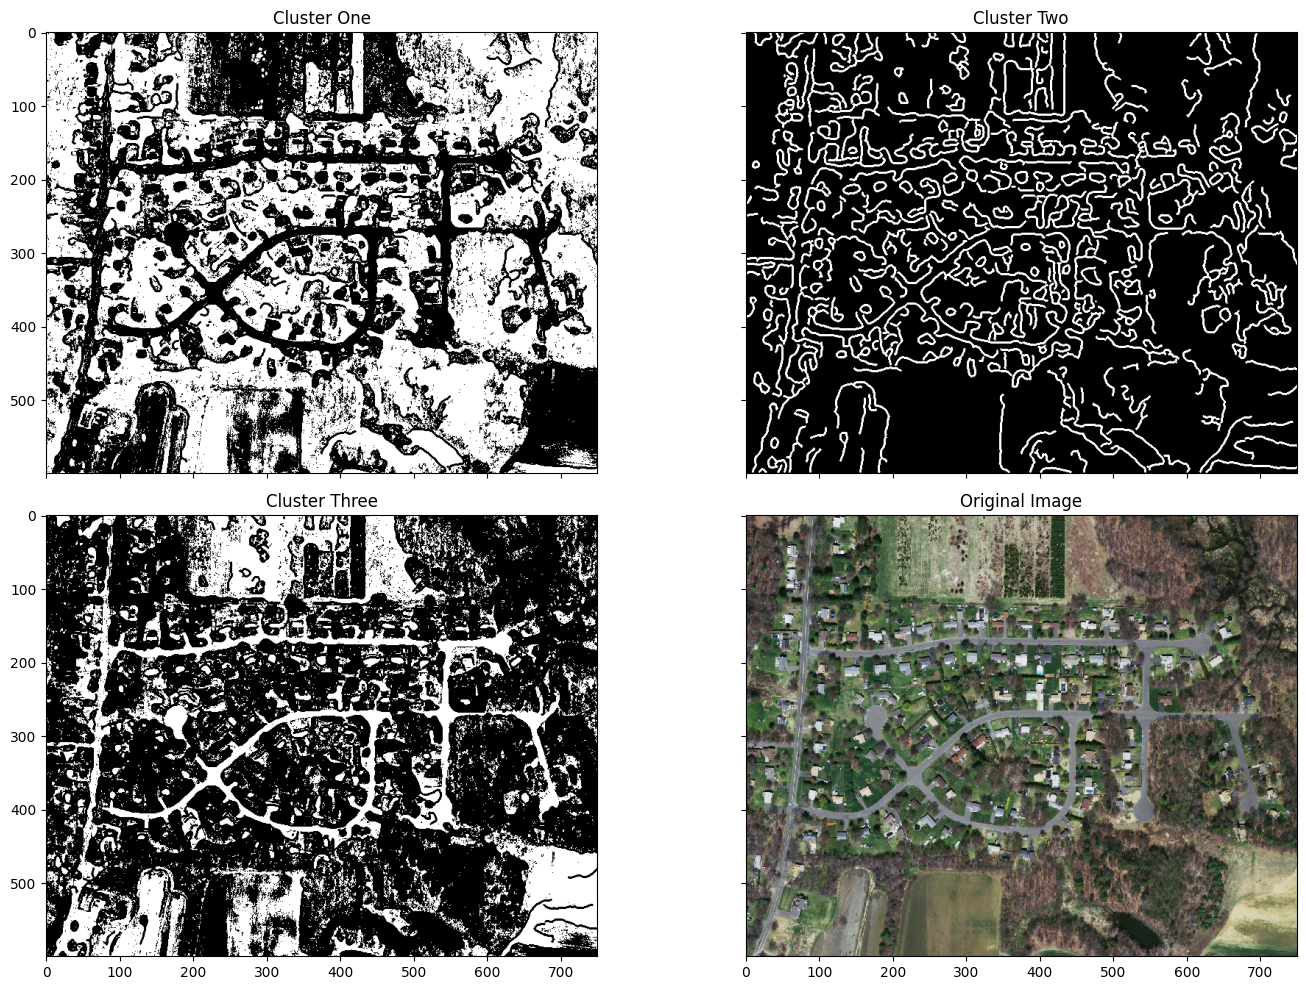

In [64]:
# Generating figure 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

cluster_one = (sk_segmented_image==0)
axes[0][0].imshow(cluster_one, cmap='gray')
axes[0][0].set_title('Cluster One')

cluster_two = (sk_segmented_image==1)
axes[0][1].imshow(cluster_two, cmap='gray')
axes[0][1].set_title('Cluster Two')

cluster_three = (sk_segmented_image==2)
axes[1][0].imshow(cluster_three, cmap='gray')
axes[1][0].set_title('Cluster Three')

axes[1][1].imshow(image)
axes[1][1].set_title('Original Image')

plt.tight_layout()
plt.show()

### Hough Transform for detecting straight edges

In [37]:
lines = transform.probabilistic_hough_line(canny_edges, threshold=20, line_length=20, line_gap=3)

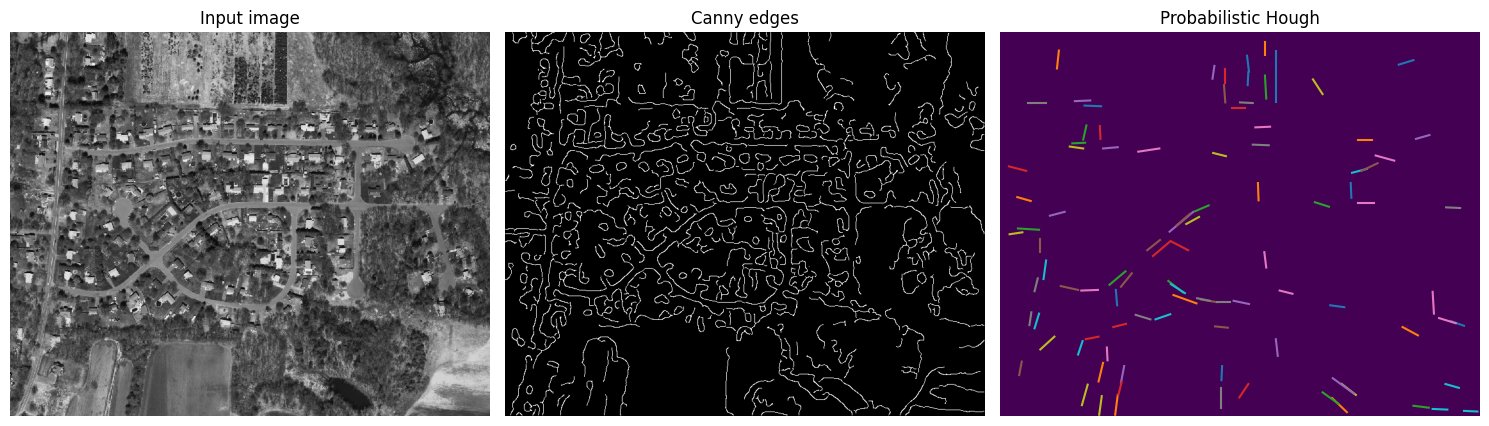

In [38]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(canny_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image_gray.shape[1]))
ax[2].set_ylim((image_gray.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()